This model is the classifier for the augmented datasets. Remember to check that you have filtering setting the way you want it :)

In [2]:
from scipy.io import loadmat
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymatreader import read_mat
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import eeg_funcs

In [30]:
# Preprocess and cut the BCI III data in to samples and form that in to a numpy array
# labels in a seperate array

# check the filepaths!
# remember to change the filtering to True/False
genpathNorm = 'C:/Users/telab/Downloads/datafiles/Norm_Unfil_X2_high_v2.npy'
genpathP3 = 'C:/Users/telab/Downloads/datafiles/P300_Unfil_X2_high_v2.npy'
filepath_3 = glob('GANs/data/Three/Train/*.mat')
d_array, d_labels = eeg_funcs.get_augdata_for_classifier_comp3(genpathP3, genpathNorm, filepath_3, False, True, True, True)
print(d_array.shape)
print(d_labels.shape)

Creating RawArray with float64 data, n_channels=65, n_times=7794
    Range : 0 ... 7793 =      0.000 ...    32.471 secs
Ready.
Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
179 events found
Event IDs: [1 2]
Not setting metadata
179 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 179 events and 160 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
Creating RawArray with float64 data, n_channels=65, n_times=7794
    Range : 0 ... 7793 =      0.000 ...    32.471 secs
Ready.
Trigger channel has a non-zero initial value of 2 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
179 events found
Event IDs: [1 2]
Not setting metadata
179 matching events found
No baseline correction applied
0 projection items activated

Classifier Modeling

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile
from sklearn.model_selection import train_test_split

In [32]:
# train and validation split for the data

X_train, X_val, y_train, y_val = train_test_split(d_array, d_labels, train_size=0.8)
print(X_train.shape)

(50713, 160, 8)


In [33]:
# classifier model 

model = keras.Sequential(
    [
        keras.Input(shape=X_train.shape[1:]),
        layers.BatchNormalization(),
        layers.Conv1D(16, kernel_size=1, strides=1, padding="same"),
        layers.Conv1D(16, kernel_size=20, strides=20, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(128, activation="tanh"),
        layers.Dropout(0.2),
        layers.Dense(128, activation="tanh"),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 160, 8)           32        
 hNormalization)                                                 
                                                                 
 conv1d_4 (Conv1D)           (None, 160, 16)           144       
                                                                 
 conv1d_5 (Conv1D)           (None, 8, 16)             5136      
                                                                 
 batch_normalization_5 (Batc  (None, 8, 16)            64        
 hNormalization)                                                 
                                                                 
 flatten_2 (Flatten)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [34]:
#compile the model
# playing around with the optimizer parameters possible

model.compile(
    #optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999),
    optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics="accuracy",
    )

In [35]:
#train the model
# playing around with the batch size and epochs possible

model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=65,
    validation_data=(X_val,y_val),
    shuffle=True
)

Epoch 1/65
793/793 [==============================] - 6s 7ms/step - loss: 0.6539 - accuracy: 0.6176 - val_loss: 0.6100 - val_accuracy: 0.6687
Epoch 2/65
793/793 [==============================] - 5s 6ms/step - loss: 0.6116 - accuracy: 0.6639 - val_loss: 0.5849 - val_accuracy: 0.6878
Epoch 3/65
793/793 [==============================] - 5s 6ms/step - loss: 0.5934 - accuracy: 0.6817 - val_loss: 0.5736 - val_accuracy: 0.7006
Epoch 4/65
793/793 [==============================] - 5s 6ms/step - loss: 0.5773 - accuracy: 0.6917 - val_loss: 0.5626 - val_accuracy: 0.7048
Epoch 5/65
793/793 [==============================] - 5s 6ms/step - loss: 0.5636 - accuracy: 0.7058 - val_loss: 0.5464 - val_accuracy: 0.7179
Epoch 6/65
793/793 [==============================] - 5s 6ms/step - loss: 0.5535 - accuracy: 0.7138 - val_loss: 0.5428 - val_accuracy: 0.7227
Epoch 7/65
793/793 [==============================] - 5s 6ms/step - loss: 0.5442 - accuracy: 0.7203 - val_loss: 0.5309 - val_accuracy: 0.7298
Epoch 

397/397 [==============================] - 1s 2ms/step
[[0.41044246 0.08439151]
 [0.02247811 0.48268791]]


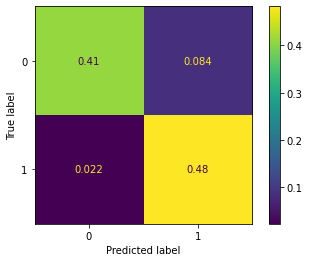

In [36]:
#putting the results of the latest training cycle in to a confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_prediction = model.predict(X_val)
y_prediction = y_prediction.flatten()
y_prediction = np.where(y_prediction > 0.5, 1, 0)

result = confusion_matrix(y_val, y_prediction, normalize='all')
print(result)
ConfusionMatrixDisplay(result).plot()

#change a correct file location!
plt.savefig("C:/Users/telab/Downloads/datafiles/pictures/CMatrix_Unfil_addedV2_Copies.png")

Evaluation of model on BCI 2 data

In [37]:
# Getting the BCI II competition data for final classification test
# remember to check filepath!
# remember to change the filtering to True/False
filepath_2 = glob('GANs/data/train/*.mat')
X_test, y_test = eeg_funcs.get_data_for_classifier_comp2(filepath_2, False, True, False)

Creating RawArray with float64 data, n_channels=65, n_times=26328
    Range : 0 ... 26327 =      0.000 ...   109.696 secs
Ready.
540 events found
Event IDs: [1 2]
Not setting metadata
540 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 540 events and 160 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
Creating RawArray with float64 data, n_channels=65, n_times=26328
    Range : 0 ... 26327 =      0.000 ...   109.696 secs
Ready.
540 events found
Event IDs: [1 2]
Not setting metadata
540 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 540 events and 160 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
Creating RawArray with float64 data, n_channels=65, n_times=35100
    Range : 0 ... 35099 =      0.000 ...   146.246 secs
Ready.
720 events found
Event IDs: [1 2]
Not setting met

In [38]:
#evaluation on the BCI II data

model.evaluate(
    x = X_test,
    y = y_test,
    batch_size = 64
)

119/119 [==============================] - 1s 5ms/step - loss: 0.8564 - accuracy: 0.6848


[0.8563705086708069, 0.6847538352012634]

237/237 [==============================] - 1s 2ms/step
[[0.62202223 0.21175225]
 [0.10349391 0.0627316 ]]


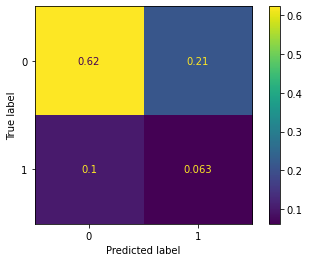

In [39]:
#Drawing confusion matrix from the BCI II test

t_prediction = model.predict(X_test)
t_prediction = t_prediction.flatten()
test_t = t_prediction.round(2)
t_prediction = np.where(t_prediction > 0.5, 1, 0)

result = confusion_matrix(y_test, t_prediction, normalize='all')
print(result)
ConfusionMatrixDisplay(result).plot()
plt.savefig("tempv2.png")